## Predicting the PCT% of price of the bitcoin for next day!

In [3]:
%reset -f

In [4]:
import pandas as pd
import numpy as np

import yfinance as yf
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

## Getting Data

### Data Loading 

In [27]:
def load_data(name, start, end):
    df = yf.download(name, start, end)
    df.columns = df.columns.droplevel('Ticker')
    df['pct_close'] = df['Adj Close'].pct_change()
    df['label'] = (df['pct_close'] > 0 ).astype('int')
    return df[['label','Open', 'High', 'Low', 'Close', 'Volume']]

In [28]:
df = load_data(name = "BTC-USD", start = "2014-01-01", end = datetime.now())

[*********************100%***********************]  1 of 1 completed


In [29]:
df

Price,label,Open,High,Low,Close,Volume
Date,,,,,,
2014-09-17 00:00:00+00:00,0,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18 00:00:00+00:00,0,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19 00:00:00+00:00,0,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20 00:00:00+00:00,1,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21 00:00:00+00:00,0,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...,...
2025-01-31 00:00:00+00:00,0,104737.562500,106026.351562,101543.882812,102405.023438,45732764360
2025-02-01 00:00:00+00:00,0,102402.796875,102755.726562,100297.710938,100655.906250,27757944848
2025-02-02 00:00:00+00:00,0,100661.539062,101430.664062,96216.078125,97688.976562,63091816853


In [30]:
df.describe()

Price,label,Open,High,Low,Close,Volume
count,3794.000000,3794.000000,3794.000000,3794.000000,3794.000000,3.794000e+03
mean,0.528466,20302.630622,20758.132330,19828.000557,20327.322166,1.892467e+10
std,0.499255,23298.431029,23806.324472,22775.175835,23329.317536,2.071209e+10
min,0.000000,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,0.000000,1257.215027,1275.662537,1242.304993,1265.897491,4.807630e+08
50%,1.000000,9458.936035,9647.977051,9261.046387,9468.167969,1.483846e+10
75%,1.000000,32136.506836,33318.439453,30943.073242,32171.524902,3.010421e+10
max,1.000000,106147.296875,109114.882812,105291.734375,106146.265625,3.509679e+11


### Data Splitting (Chronological)

In [31]:
def chronological_split(data, ratios = (0.7, 0.2, 0.1)):
    n = len(data)
    train_end = int(n * ratios[0])
    val_end = train_end + int(n * ratios[1])
    return data.iloc[:train_end], data.iloc[train_end:val_end], data.iloc[val_end:]

In [32]:
df_train, df_val, df_test = chronological_split(df)

In [33]:
df_train.shape, df_val.shape, df_test.shape

((2655, 6), (758, 6), (381, 6))

### Data Normalization 

In [34]:


def normalize(df_train, df_val, df_test, target_column="label"):
    """
    Normalizes the datasets using the mean and standard deviation from the training set.

    Parameters:
        df_train (pd.DataFrame): The training data.
        df_val (pd.DataFrame): The validation data.
        df_test (pd.DataFrame): The test data.
        target_column (str): Name of the target column (binary classification).
        
    Returns:
        tuple: (X_train, X_val, X_test, y_train, y_val, y_test, data_mean, data_std)
    """
    # Separate features (X) and target (y)
    y_train = df_train[target_column]  # Keep labels separate
    y_val = df_val[target_column]
    y_test = df_test[target_column]

    X_train = df_train.drop(columns=[target_column])
    X_val = df_val.drop(columns=[target_column])
    X_test = df_test.drop(columns=[target_column])

    # Compute normalization statistics on training set only
    data_mean = X_train.mean()
    data_std = X_train.std()

    # Normalize features using training set statistics
    X_train = (X_train - data_mean) / data_std
    X_val = (X_val - data_mean) / data_std
    X_test = (X_test - data_mean) / data_std

    return X_train, X_val, X_test, y_train, y_val, y_test, data_mean, data_std

In [35]:
X_train, X_val, X_test, y_train, y_val, y_test, data_mean, data_std = normalize(df_train, df_val, df_test)

In [38]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2655, 5), (758, 5), (381, 5), (2655,), (758,), (381,))

In [85]:
data_std

Price
Adj Close    1.556895e+04
Open         1.555682e+04
High         1.598993e+04
Low          1.506178e+04
Close        1.556895e+04
Volume       2.009187e+10
dtype: float64

### Sequence Generation 

In [87]:
def create_sequences(data, seq_length=30, pred_length=1):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length - pred_length + 1):
        sequences.append(data.iloc[i:i+seq_length].values)
        targets.append(data['Adj Close'].iloc[i+seq_length:i+seq_length+pred_length].values)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

In [88]:
# Create datasets
X_train_seq, y_train_seq = create_sequences(X_train)
X_val_seq, y_val_seq = create_sequences(X_val)
X_test_seq, y_test_seq = create_sequences(X_test)

In [89]:
X_test_seq.shape

torch.Size([350, 30, 6])

In [90]:
X_train_seq[1,:,0]

tensor([-0.6546, -0.6565, -0.6556, -0.6563, -0.6561, -0.6539, -0.6547, -0.6554,
        -0.6559, -0.6562, -0.6577, -0.6578, -0.6570, -0.6572, -0.6578, -0.6588,
        -0.6608, -0.6613, -0.6607, -0.6603, -0.6592, -0.6584, -0.6587, -0.6586,
        -0.6576, -0.6568, -0.6561, -0.6565, -0.6573, -0.6572])

In [91]:
y_train_seq[0]

tensor([-0.6572])

### DataLoader Setup 

In [92]:
from torch.utils.data import TensorDataset, DataLoader

In [93]:
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train_seq, y_train_seq), batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val_seq, y_val_seq), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_seq, y_test_seq), batch_size=BATCH_SIZE, shuffle=False)

## Model GRU

In [94]:
import torch
import torch.nn as nn

class BitcoinBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super().__init__()
        # First Bi-LSTM + Dropout
        self.bilstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Second Bi-LSTM + Dropout
        self.bilstm2 = nn.LSTM(
            input_size=hidden_size*2,  # Bidirectional doubles output size
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Final regression layer
        self.fc = nn.Linear(hidden_size*2, 1)  # Single output neuron
        
        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Layer 1
        x, _ = self.bilstm1(x)
        x = self.dropout1(x)
        x = self.relu(x)  # ReLU after first layer
        
        # Layer 2
        x, _ = self.bilstm2(x)
        x = self.dropout2(x)
        x = self.relu(x)  # ReLU after second layer
        
        # Final prediction
        x = self.fc(x[:, -1, :])  # Use last timestep's output
        return x

In [95]:
class HyperbolicCosineLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, preds, targets):
        return torch.mean(torch.cosh(preds - targets))

# Usage
criterion = HyperbolicCosineLoss()

In [96]:
torch.mps.empty_cache()

In [97]:
# Hyperparameters
input_size = 6  # ['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']
hidden_size = 512
dropout_rate = 0.1
#fc_units = 1

model = BitcoinBiLSTM(input_size, hidden_size, dropout_rate)
print(model)

BitcoinBiLSTM(
  (bilstm1): LSTM(6, 512, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (bilstm2): LSTM(1024, 512, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
)


In [98]:
# --- Training Configuration ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
criterion = nn.HuberLoss()  # More robust than MSE

In [99]:
model

BitcoinBiLSTM(
  (bilstm1): LSTM(6, 512, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (bilstm2): LSTM(1024, 512, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
  (relu): ReLU()
)

## Train & Evaluation

In [100]:
# --- Training Loop ---
def train_model(model, epochs=50):
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_loss += criterion(outputs, y_val).item()
        
        avg_train_loss = train_loss/len(train_loader)
        avg_val_loss = val_loss/len(val_loader)
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        
    model.load_state_dict(torch.load('best_model.pth'))
    return model

In [101]:
model = train_model(model)

Epoch 1/50 | Train Loss: 0.0809 | Val Loss: 0.8314
Epoch 2/50 | Train Loss: 0.2335 | Val Loss: 1.2440
Epoch 3/50 | Train Loss: 0.5079 | Val Loss: 0.5877
Epoch 4/50 | Train Loss: 0.3118 | Val Loss: 0.0650
Epoch 5/50 | Train Loss: 0.0305 | Val Loss: 0.0200
Epoch 6/50 | Train Loss: 0.0139 | Val Loss: 0.0357
Epoch 7/50 | Train Loss: 0.0115 | Val Loss: 0.0183
Epoch 8/50 | Train Loss: 0.0147 | Val Loss: 0.0099
Epoch 9/50 | Train Loss: 0.0087 | Val Loss: 0.0226
Epoch 10/50 | Train Loss: 0.0090 | Val Loss: 0.0390
Epoch 11/50 | Train Loss: 0.0083 | Val Loss: 0.0260
Epoch 12/50 | Train Loss: 0.0051 | Val Loss: 0.0207
Epoch 13/50 | Train Loss: 0.0079 | Val Loss: 0.0246
Epoch 14/50 | Train Loss: 0.0054 | Val Loss: 0.0160
Epoch 15/50 | Train Loss: 0.0051 | Val Loss: 0.0112
Epoch 16/50 | Train Loss: 0.0046 | Val Loss: 0.0086
Epoch 17/50 | Train Loss: 0.0043 | Val Loss: 0.0070
Epoch 18/50 | Train Loss: 0.0042 | Val Loss: 0.0063
Epoch 19/50 | Train Loss: 0.0040 | Val Loss: 0.0055
Epoch 20/50 | Train L

/var/folders/8p/ztyyqgbs6_l4yvpdgl86tmsr0000gn/T/ipykernel_1566/2015581071.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

In [102]:
# --- Evaluation ---
def inverse_transform(data, mean, std):
    return data * std + mean

def evaluate(model, loader):
    model.eval()
    predictions, truths = [], []
    
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).cpu().numpy()
            
            # Inverse normalization
            preds = inverse_transform(preds, data_mean['Adj Close'], data_std['Adj Close'])
            y = inverse_transform(y.cpu().numpy(), data_mean['Adj Close'], data_std['Adj Close'])
            
            predictions.extend(preds)
            truths.extend(y)
    
    return np.array(predictions), np.array(truths)

In [103]:
# --- Visualization ---
def plot_predictions(true, pred, title="Predictions vs True Values"):
    plt.figure(figsize=(12, 6))
    plt.plot(true[:, 0], label='True (First Day)', alpha=0.7)
    plt.plot(pred[:, 0], label='Predicted (First Day)', linestyle='--')
    plt.title(title)
    plt.xlabel("Samples")
    plt.ylabel("Bitcoin Price (USD)")
    plt.legend()
    plt.show()


In [104]:
# Generate predictions
test_preds, test_true = evaluate(model, test_loader)

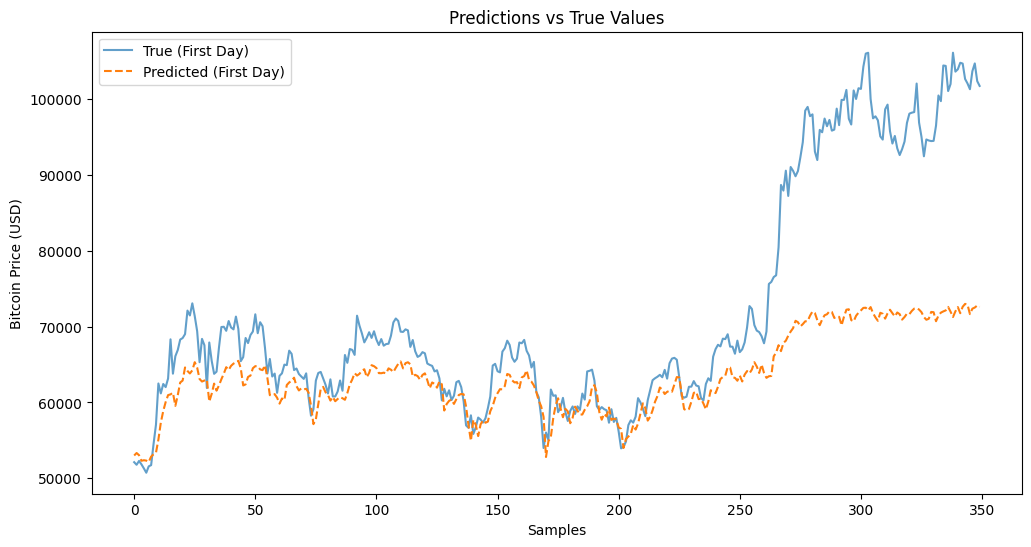

In [105]:
plot_predictions(test_true, test_preds)

In [108]:
test_true.shape

(350, 1)

In [63]:
test_preds.shape

(372, 1)

In [109]:
test_true[-1]

array([101764.28], dtype=float32)

In [110]:
test_preds[-1]

array([72613.46], dtype=float32)

In [111]:
test_true[-1] - test_preds[-1]

array([29150.82], dtype=float32)

In [116]:
def alert_price_increase(today_price, predicted_price, threshold=0.20):
    """
    Checks if the predicted price increase is above a given threshold.
    
    Parameters:
        today_price (float): The current price of Bitcoin.
        predicted_price (float): The model's predicted price for tomorrow.
        threshold (float): The fractional threshold for alerting (default is 0.20 for 20%).
        
    Returns:
        bool: True if the predicted increase is above the threshold, False otherwise.
    """
    # Calculate the relative change (as a fraction)
    change_fraction = (predicted_price - today_price) / today_price

    # Check if the change exceeds the threshold
    if change_fraction > threshold:
        print(f"Alert: Predicted price increase is {change_fraction*100:.2f}% which is above the threshold of {threshold*100:.2f}%!")
        return True
    else:
        print(f"Predicted price change is {change_fraction*100:.2f}%, which is within the normal range.")
        return False

# Example usage:
today_price = test_preds[-2][0]  # Example current price
predicted_price = test_preds[-1][0]  # Example predicted price for tomorrow

if alert_price_increase(today_price, predicted_price):
    # Trigger additional logic if needed (e.g., send an alert, execute a trade, etc.)
    pass


Predicted price change is -0.24%, which is within the normal range.


In [117]:
test_preds[-1], test_preds[-2]

(array([72613.46], dtype=float32), array([72791.02], dtype=float32))

In [119]:
(test_preds[-1] - test_preds[-2]) / test_preds[-1]

array([-0.00244531], dtype=float32)

### save model

In [41]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import yfinance as yf

# ======================
# 1. Data Preparation
# ======================

# Load and preprocess data
def load_and_preprocess(train_ratio, val_ratio):
    # Download data
    df = yf.download("BTC-USD", start="2014-01-01", end=datetime.now())
    df = df[['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Chronological split
    train_size = int(train_ratio * len(df))
    val_size = int(val_ratio * len(df))
    train = df.iloc[:train_size]
    val = df.iloc[train_size:train_size+val_size]
    test = df.iloc[train_size+val_size:]
    
    # Normalize using training stats
    scaler = StandardScaler().fit(train)
    train_scaled = scaler.transform(train)
    val_scaled = scaler.transform(val)
    test_scaled = scaler.transform(test)
    
    return train_scaled, val_scaled, test_scaled, scaler

# Create sequences
def create_sequences(data, seq_length=30, pred_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_length + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+pred_length, 0])  # Predict Adj Close
    return np.array(X), np.array(y)

# ======================
# 2. Model Architecture
# ======================

class BitcoinBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate):
        super().__init__()
        # First Bi-LSTM + Dropout
        self.bilstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Second Bi-LSTM + Dropout
        self.bilstm2 = nn.LSTM(
            input_size=hidden_size*2,  # Bidirectional doubles output size
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Final regression layer
        self.fc = nn.Linear(hidden_size*2, 1)  # Single output neuron
        
        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Layer 1
        x, _ = self.bilstm1(x)
        x = self.dropout1(x)
        x = self.relu(x)  # ReLU after first layer
        
        # Layer 2
        x, _ = self.bilstm2(x)
        x = self.dropout2(x)
        x = self.relu(x)  # ReLU after second layer
        
        # Final prediction
        x = self.fc(x[:, -1, :])  # Use last timestep's output
        return x

# ======================
# 3. Training Setup
# ======================

class CoshLoss(nn.Module):
    def forward(self, pred, target):
        return torch.mean(torch.cosh(pred - target))

# Initialize components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BitcoinBiLSTM(input_size=6, hidden_size=512, dropout_rate=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
criterion = CoshLoss()

# ======================
# 4. Training Loop
# ======================

def train_model(train_loader, val_loader, epochs=100):
    best_loss = float('inf')
    patience_counter = 0
    patience = 7
    
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                epoch_val_loss += criterion(outputs, y_val).item()
        
        # Calculate metrics
        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_val_loss = epoch_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        # Progress monitoring
        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
            
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, val_losses

# ======================
# 5. Evaluation
# ======================

def evaluate_model(test_loader, scaler):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            
            # Inverse transform predictions
            preds = outputs.cpu().numpy()
            preds = scaler.inverse_transform(
                np.concatenate([
                    preds, 
                    np.zeros((preds.shape[0], 5))  # Add dummy columns for inverse transform
                ], axis=1)
            )[:, 0]  # Extract first column (Adj Close)
            
            # Inverse transform actuals
            trues = y_test.cpu().numpy()
            trues = scaler.inverse_transform(
                np.concatenate([
                    trues.reshape(-1,1), 
                    np.zeros((trues.size, 5))
                ], axis=1)
            )[:, 0]
            
            predictions.extend(preds)
            actuals.extend(trues)
    
    return np.array(predictions), np.array(actuals)


In [5]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime

# ======================
# Modified Implementation
# ======================

def main_grid_search():
    # Grid parameters
    seq_lengths = [7, 15, 30]
    batch_sizes = [32, 64, 128]
    test_ratio = 0.2  # Fixed test set ratio
    
    results = []
    
    # Load base data once
    df = yf.download("BTC-USD", start="2014-01-01", end=datetime.now())
    df = df[['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Fixed split indices
    total_size = len(df)
    test_size = int(test_ratio * total_size)
    trainval_size = total_size - test_size
    train_size = int(0.8 * trainval_size)  # 80% of trainval for training
    
    for seq_length in tqdm(seq_lengths, desc="Sequence Lengths"):
        for batch_size in tqdm(batch_sizes, desc="Batch Sizes", leave=False):
            # Create sequences with current seq_length
            def create_sequences(data):
                X, y = [], []
                for i in range(len(data) - seq_length):
                    X.append(data[i:i+seq_length])
                    y.append(data[i+seq_length, 0])  # Predict Adj Close
                return np.array(X), np.array(y)
            
            # Split and normalize
            train = df.iloc[:train_size]
            val = df.iloc[train_size:trainval_size]
            test = df.iloc[trainval_size:]
            
            # Normalize using training stats
            scaler = StandardScaler().fit(train)
            train_scaled = scaler.transform(train)
            val_scaled = scaler.transform(val)
            test_scaled = scaler.transform(test)
            
            # Create sequences
            X_train, y_train = create_sequences(train_scaled)
            X_val, y_val = create_sequences(val_scaled)
            X_test, y_test = create_sequences(test_scaled)
            
            # Create DataLoaders
            train_loader = DataLoader(
                TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train)),
                batch_size=batch_size,
                shuffle=False
            )
            test_loader = DataLoader(
                TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test)),
                batch_size=batch_size,
                shuffle=False
            )
            
            # Initialize fresh model for each combination
            model = BitcoinBiLSTM(input_size=6, hidden_size=128, dropout_rate=0.2).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Training loop (simplified)
            model.train()
            for epoch in range(30):  # Reduced epochs for demo
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    outputs = model(X_batch.to(device))
                    loss = criterion(outputs, y_batch.to(device))
                    loss.backward()
                    optimizer.step()
            
            # Evaluation
            model.eval()
            all_preds, all_actuals = [], []
            with torch.no_grad():
                for X_test, y_test in test_loader:
                    preds = model(X_test.to(device)).cpu().numpy()
                    
                    # Inverse transform predictions
                    dummy = np.zeros((len(preds), 5))
                    preds_denorm = scaler.inverse_transform(
                        np.hstack([preds.reshape(-1,1), dummy])
                    )[:, 0]
                    
                    # Inverse transform actuals
                    actuals = y_test.numpy()
                    actuals_denorm = scaler.inverse_transform(
                        np.hstack([actuals.reshape(-1,1), dummy])
                    )[:, 0]
                    
                    all_preds.extend(preds_denorm)
                    all_actuals.extend(actuals_denorm)
            
            # Store results
            for pred, actual in zip(all_preds, all_actuals):
                results.append({
                    'len_train': len(X_train),
                    'len_val': len(X_val),
                    'len_test': len(X_test),
                    'seq_length': seq_length,
                    'batch_size': batch_size,
                    'preds': pred,
                    'actual': actual,
                    'error': actual - pred
                })
    
    return pd.DataFrame(results)

# ======================
# Usage
# ======================
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = CoshLoss()
    
    results_df = main_grid_search()
    
    # Save results
    results_df.to_csv("grid_search_results.csv", index=False)
    
    # Display summary
    print("\nGrid Search Results Summary:")
    print(results_df.groupby(['seq_length', 'batch_size']).agg({
        'error': 'mean',
        'len_train': 'first',
        'len_val': 'first',
        'len_test': 'first'
    }).reset_index())

[*********************100%***********************]  1 of 1 completed
Sequence Lengths:   0%|                                   | 0/3 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [57]:
import torch

# Assume 'model' is your trained PyTorch model
model_path = "models/bitcoin_model.pth"

torch.save(model.state_dict(), model_path)  # Save model weights
print(f"Model saved to {model_path}")


Model saved to models/bitcoin_model.pth


In [58]:
import os
os.getcwd()

'/Users/armand/Desktop/ML/Pytorch/TimeSeries'